In [4]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from projimmo.data import *
from projimmo.preprocessor import *
from projimmo.model import *
from projimmo.optimize_model import *

In [2]:

query = f"""
        SELECT *
        FROM `{GCP_PROJECT}`.{BQ_DATASET}.DVF_{DATA_YEAR}
    """
#chemin d'accès à nos fichiers locaux
data_query_cache_path=Path(f"raw_data/valeursfoncieres-{DATA_YEAR}.txt")

# import de nos data, ici à partir du fichier mais plus tard dans la base de data de bigquer
df= get_data_with_cache(query=query,
gcp_project=GCP_PROJECT,
        cache_path=data_query_cache_path,
        data_has_header=True
   )

#Pour écrire dans big query le df notre choix
#load_data_to_bq(
#        df_de_notre_choix,
 #       gcp_project=GCP_PROJECT,
 #       bq_dataset=BQ_DATASET,
 #       table=f'processed_{DATA_SIZE}',
 #       truncate=True
  #  )
#appel à la fonction clean_data
df_0=clean_data(df)
#appel à la fonction clean_outliers
df_1=clean_outliers(df_0)
#on passe notre df dans la pipeline
df_2=preprocess_features(df_1)


Load data from local CSV...
✅ Data loaded, with shape (3727005, 43)
✅ X_processed, with shape (75664, 89)


In [7]:
df_2.head(5)

,surface_reelle_bati,surface_terrain,somme_surface_carrez,valeur_fonciere,code_type_local_2,type_de_voie_ACH,type_de_voie_ALL,type_de_voie_ART,type_de_voie_AV,type_de_voie_BD,...,type_de_voie_VOIE,type_de_voie_VTE,type_de_voie_ZAC,type_de_voie_ZI,type_de_voie_nan,nombre_pieces_principales,month_mutation,year_mutation,departement,nombre_de_lots
0,1.312723,0.0,1.215123,0.071429,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0
1,1.312723,0.0,1.135831,0.142857,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0
2,-0.374117,0.0,-0.169891,-0.607143,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
3,0.064462,0.0,0.196049,-0.380952,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0
4,0.300619,0.0,0.302316,-0.357143,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0


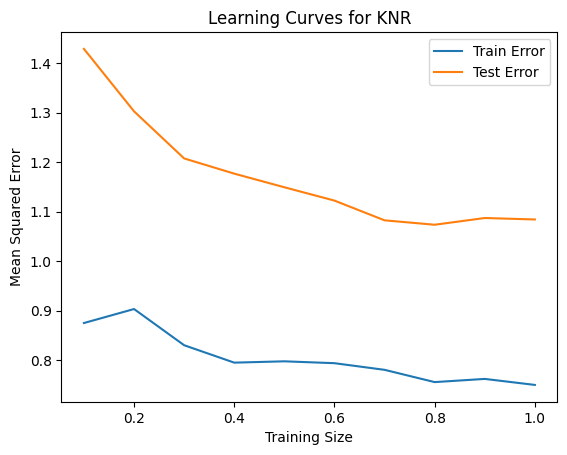

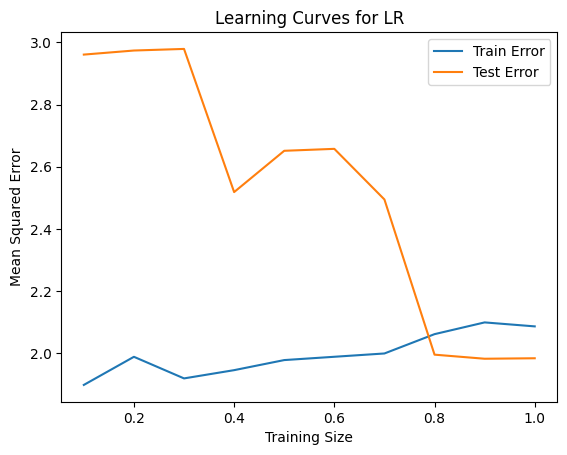

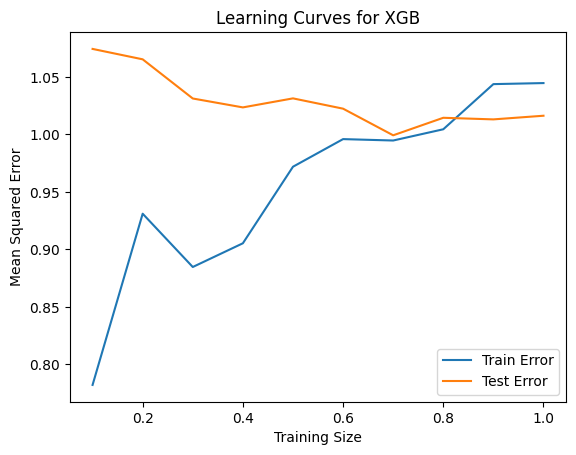

In [5]:



def plot_learning_curves(X_train, X_test, y_train, y_test, model, model_type):
    train_errors, test_errors = [], []
    train_sizes = np.linspace(0.1, 1.0, 10)

    for train_size in train_sizes:
        X_train_subset = X_train[:int(train_size * len(X_train))]
        y_train_subset = y_train[:int(train_size * len(y_train))]

        model.fit(X_train_subset, y_train_subset)

        y_train_pred = model.predict(X_train_subset)
        y_test_pred = model.predict(X_test)

        train_errors.append(mean_squared_error(y_train_subset, y_train_pred))
        test_errors.append(mean_squared_error(y_test, y_test_pred))

    plt.plot(train_sizes, train_errors, label='Train Error')
    plt.plot(train_sizes, test_errors, label='Test Error')
    plt.title(f'Learning Curves for {model_type}')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

# Split your data
X_train, X_test, y_train, y_test = split_df(df_2)

# Initialize and train your models
knr_model = initialize_model("KNR")
lr_model = initialize_model("LR")
xgb_model = initialize_model("XGB")

knr_model = train_model(X_train, y_train, knr_model)
lr_model = train_model(X_train, y_train, lr_model)
xgb_model = train_model(X_train, y_train, xgb_model)

# Plot learning curves
plot_learning_curves(X_train, X_test, y_train, y_test, knr_model, "KNR")
plot_learning_curves(X_train, X_test, y_train, y_test, lr_model, "LR")
plot_learning_curves(X_train, X_test, y_train, y_test, xgb_model, "XGB")

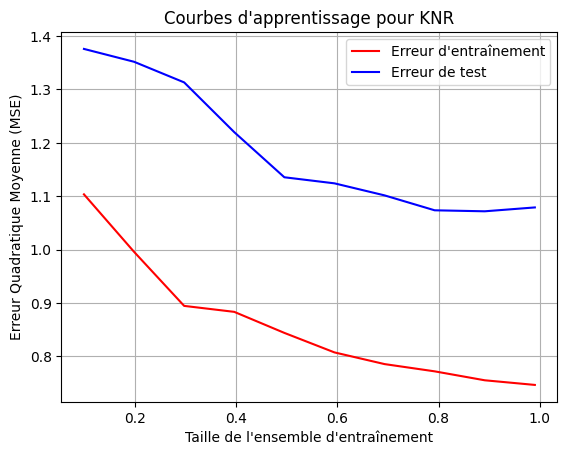

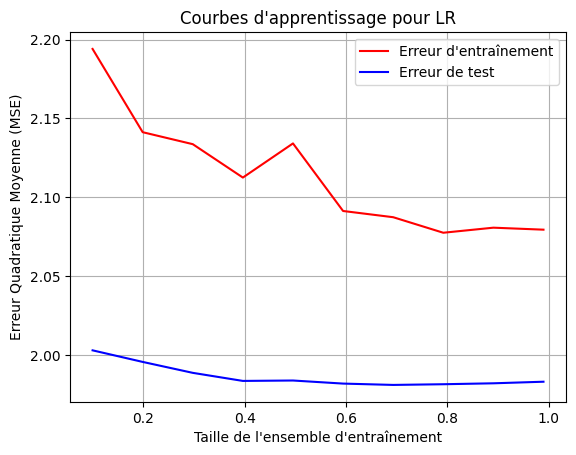

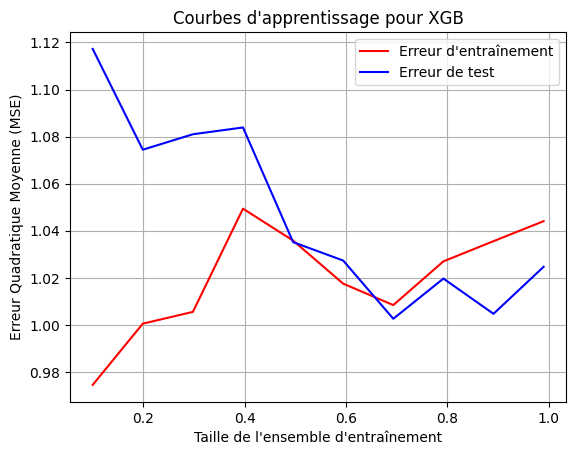

In [6]:
def plot_learning_curves(X_train, X_test, y_train, y_test, model, model_type):
    """
    Trace les courbes d'apprentissage en fonction de la taille de l'ensemble d'entraînement.
    """
    train_errors, test_errors = [], []
    train_sizes = np.linspace(0.1, 0.99, 10)  # Remplacer 1.0 par 0.99

    for train_size in train_sizes:
        # Créer un sous-ensemble de l'ensemble d'entraînement basé sur train_size
        X_train_subset, _, y_train_subset, _ = train_test_split(
            X_train, y_train, train_size=train_size, random_state=42
        )

        # Entraîner le modèle avec les sous-ensembles
        model.fit(X_train_subset, y_train_subset)

        # Prédictions sur les ensembles d'entraînement et de test
        y_train_pred = model.predict(X_train_subset)
        y_test_pred = model.predict(X_test)

        # Calcul des erreurs
        train_errors.append(mean_squared_error(y_train_subset, y_train_pred))
        test_errors.append(mean_squared_error(y_test, y_test_pred))

    # Tracer les erreurs
    plt.plot(train_sizes, train_errors, 'r-', label='Erreur d\'entraînement')
    plt.plot(train_sizes, test_errors, 'b-', label='Erreur de test')
    plt.title(f'Courbes d\'apprentissage pour {model_type}')
    plt.xlabel('Taille de l\'ensemble d\'entraînement')
    plt.ylabel('Erreur Quadratique Moyenne (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Split the data
X_train, X_test, y_train, y_test = split_df(df_2)

# Initialize the models
knr_model = initialize_model("KNR")
lr_model = initialize_model("LR")
xgb_model = initialize_model("XGB")

# Train and plot learning curves for KNR
plot_learning_curves(X_train, X_test, y_train, y_test, knr_model, "KNR")

# Train and plot learning curves for Linear Regression
plot_learning_curves(X_train, X_test, y_train, y_test, lr_model, "LR")

# Train and plot learning curves for XGBoost
plot_learning_curves(X_train, X_test, y_train, y_test, xgb_model, "XGB")

In [ ]:
#Dans le premier extrait de code, les modèles sont entraînés à l'aide de la fonction train_model avant d'appeler la fonction plot_learning_curves.
#Cela signifie que les modèles sont entraînés une seule fois avec l'ensemble complet des données d'entraînement,
# puis les courbes d'apprentissage sont tracées en fonction de sous-ensembles de ces données.

#Dans le deuxième extrait de code,
# les modèles sont entraînés à l'intérieur de la fonction plot_learning_curves.
# Cela signifie que pour chaque sous-ensemble des données d'entraînement,
# le modèle est entraîné à partir de zéro. Cette approche nous permet de voir comment la performance du modèle évolue lorsque nous augmentons la taille des données d'entraînement.

In [11]:

# Définir la grille de paramètres
PARAM_GRID_KNN = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Initialiser le modèle KNN
knn = KNeighborsRegressor()

# Configurer GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn, param_grid=PARAM_GRID_KNN, cv=5, scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best score for KNN:", -grid_search_knn.best_score_)

Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
Best score for KNN: 1.0931745221359528


In [16]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
PARAM_GRID_RIDGE = {
    'alpha': [0.1, 1, 10, 100]
}

PARAM_GRID_LASSO = {
    'alpha': [0.1, 1, 10, 100]
}

# Initialiser les modèles Ridge et Lasso
ridge = Ridge()
lasso = Lasso()

# Configurer GridSearchCV pour Ridge
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=PARAM_GRID_RIDGE, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_ridge.fit(X_train, y_train)

# Afficher les meilleurs paramètres et score pour Ridge
print("Best parameters for Ridge:", grid_search_ridge.best_params_)
print("Best score for Ridge:", -grid_search_ridge.best_score_)

# Configurer GridSearchCV pour Lasso
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=PARAM_GRID_LASSO, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_lasso.fit(X_train, y_train)

# Afficher les meilleurs paramètres et score pour Lasso
print("Best parameters for Lasso:", grid_search_lasso.best_params_)
print("Best score for Lasso:", -grid_search_lasso.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Ridge: {'alpha': 1}
Best score for Ridge: 2.1078011166165163
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Lasso: {'alpha': 0.1}
Best score for Lasso: 2.163298079357784


In [14]:

param_grid = {
    'objective': ['reg:squarederror', 'reg:squaredlogerror'],
    'n_estimators': [100, 200],
    'eta': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6,10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

/home/fayssal/.pyenv/versions/3.10.6/envs/projimmo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
4050 fits failed out of a total of 8100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fayssal/.pyenv/versions/3.10.6/envs/projimmo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fayssal/.pyenv/versions/3.10.6/envs/projimmo/lib/python3.10/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/home/fayssal/.pyenv/versions/3.10.6/envs/projimmo/lib/python3.10/site-p

Best parameters: {'colsample_bytree': 0.8, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.9}


In [ ]:
#objective :
#'reg:squarederror': Utilisé pour la régression avec une fonction de perte d'erreur quadratique.
#'reg:squaredlogerror': Utilisé pour la régression avec une fonction de perte d'erreur quadratique logarithmique, souvent utilisé lorsque la cible est très variable.

#n_estimators :
#Le nombre d'arbres à construire dans le modèle XGBoost. Plus de n_estimators peut améliorer la performance jusqu'à un certain point mais augmenter le temps de calcul.

# eta (ou learning_rate) :
#Le taux d'apprentissage. Plus petit signifie une mise à jour plus lente des poids et donc un entraînement plus stable. Valeurs courantes : 0.01, 0.1, 0.2.

#max_depth :
#La profondeur maximale des arbres. Des arbres plus profonds peuvent capturer plus de détails mais aussi risquer de surapprendre. Valeurs courantes : 3, 4, 5, 6, 10.

#learning_rate :
#Le taux d'apprentissage qui est parfois utilisé comme synonyme de eta. Cela ajuste la contribution de chaque arbre aux prédictions finales.

#subsample :
#La fraction des échantillons à utiliser pour chaque arbre. Cela aide à prévenir le surapprentissage. Valeurs courantes : 0.7, 0.8, 0.9.

#colsample_bytree :
#La fraction des colonnes à utiliser pour chaque arbre. Aide également à éviter le surapprentissage. Valeurs courantes : 0.7, 0.8, 0.9.
